In [13]:
import numpy as np
import matplotlib.pyplot as plt
import scipy 
import emcee

In [7]:
data = np.load("/home/robertoinfurna/astrostatistics_bicocca_2024/solutions/transient.npy")

In [8]:
def burst(time,b,A,alpha,t0):
    if time < t0: return b
    else: return b+A*np.exp(-alpha*(t-t0))
    

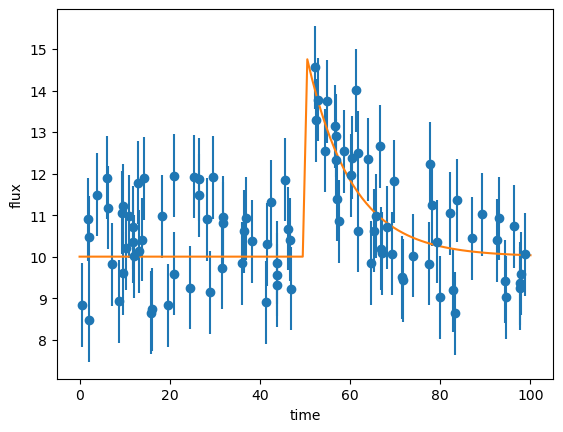

In [9]:
plt.errorbar(data[:,0],data[:,1],data[:,2],linestyle='None', marker='o')
plt.xlabel("time")
plt.ylabel("flux")

times = np.linspace(0,100,100)
analytic=[]
for t in times: 
    analytic.append(burst(t,10,5,0.1,50))

plt.plot(times,analytic)

In [23]:
#Likelihood
def gaussian_probability(x, mu,sigma):
    return (1.0 / (np.sqrt(2.0 * np.pi) * sigma))*np.exp(-(x-mu)**2 /(2*sigma**2)) 

#burst(t,10,5,0.1,50)
#burst(time,b,A,alpha,t0)

def likelihood_gaus(data,b,A,alpha,t0): 
    L = 1.
    for i in range(len(data)):
        L = L*gaussian_probability(data[i,1],burst(data[i,0],b,A,alpha,t0), data[i,2])
        #likelihood = norm(data-burst(), 1).pdf(data).prod()
    return L

def priors(b,A,alpha,t0): 
    if b >= 0 and b <= 50 and A >= 0 and A <= 50 and t0 >= 0 and t0 <= 100 and alpha >= np.exp(-5) and alpha <= np.exp(5):
        return 1
    else: return 0
    

def myPosterior(data,b,A,alpha,t0):
    return likelihood_gaus(data,b,A,alpha,t0) * priors(b,A,alpha,t0)

# emcee wants ln of posterior pdf
def myLogPosterior(param, data):
    b,A,alpha,t0 = param
    return np.log(myPosterior(data,b,A,alpha,t0))



In [26]:
ndim = 4  # number of parameters in the model
nwalkers = 8  # number of MCMC walkers
burn = 10000  # "burn-in" period to let chains stabilize
nsteps = 40000  # number of MCMC steps to take **for each walker**

# initialize parameters
starting_guesses =  np.array( [scipy.stats.uniform(loc=0,scale=50).rvs(size=nwalkers), \
                   scipy.stats.uniform(loc=0,scale=50).rvs(size=nwalkers), \
                   scipy.stats.uniform(loc=0,scale=100).rvs(size=nwalkers), \
                   scipy.stats.loguniform.rvs(np.exp(-5),np.exp(5),size=nwalkers)]).T

# the function call where all the work happens: 
sampler = emcee.EnsembleSampler(nwalkers, ndim, myLogPosterior, args=[data])
sampler.run_mcmc(starting_guesses, nsteps, progress=True)
 
# sampler.chain is of shape (nwalkers, nsteps, ndim)
# throw-out the burn-in points and reshape:
emcee_trace  = sampler.chain[:, burn:, :].reshape(-1, ndim)

print("done")


/tmp/ipykernel_12933/1461421042.py:27: RuntimeWarning: divide by zero encountered in log
  return np.log(myPosterior(data,b,A,alpha,t0))
  0%|                                                 | 0/40000 [00:00<?, ?it/s]/tmp/ipykernel_12933/2148421848.py:3: RuntimeWarning: overflow encountered in exp
  else: return b+A*np.exp(-alpha*(t-t0))
/tmp/ipykernel_12933/1461421042.py:3: RuntimeWarning: overflow encountered in scalar power
  return (1.0 / (np.sqrt(2.0 * np.pi) * sigma))*np.exp(-(x-mu)**2 /(2*sigma**2))
  2%|▋                                     | 744/40000 [00:03<02:59, 219.08it/s]/tmp/ipykernel_12933/2148421848.py:3: RuntimeWarning: overflow encountered in scalar multiply
  else: return b+A*np.exp(-alpha*(t-t0))
100%|████████████████████████████████████| 40000/40000 [02:55<00:00, 228.17it/s]

done


In [29]:
print(sampler.chain)

[[[3.08905200e+01 1.77139813e+01 5.25754891e+01 3.35524616e-01]
  [3.08905200e+01 1.77139813e+01 5.25754891e+01 3.35524616e-01]
  [3.08905200e+01 1.77139813e+01 5.25754891e+01 3.35524616e-01]
  ...
  [3.08905200e+01 1.77139813e+01 5.25754891e+01 3.35524616e-01]
  [3.08905200e+01 1.77139813e+01 5.25754891e+01 3.35524616e-01]
  [3.08905200e+01 1.77139813e+01 5.25754891e+01 3.35524616e-01]]

 [[2.66446273e+01 1.40810642e+01 2.48504632e+01 2.79865470e-02]
  [2.66446273e+01 1.40810642e+01 2.48504632e+01 2.79865470e-02]
  [2.66446273e+01 1.40810642e+01 2.48504632e+01 2.79865470e-02]
  ...
  [2.66446273e+01 1.40810642e+01 2.48504632e+01 2.79865470e-02]
  [2.66446273e+01 1.40810642e+01 2.48504632e+01 2.79865470e-02]
  [2.66446273e+01 1.40810642e+01 2.48504632e+01 2.79865470e-02]]

 [[1.10237026e+01 1.41370383e+01 7.18068782e+01 3.94044852e-01]
  [1.10237026e+01 1.41370383e+01 7.18068782e+01 3.94044852e-01]
  [1.10237026e+01 1.41370383e+01 7.18068782e+01 3.94044852e-01]
  ...
  [1.07903711e+01 

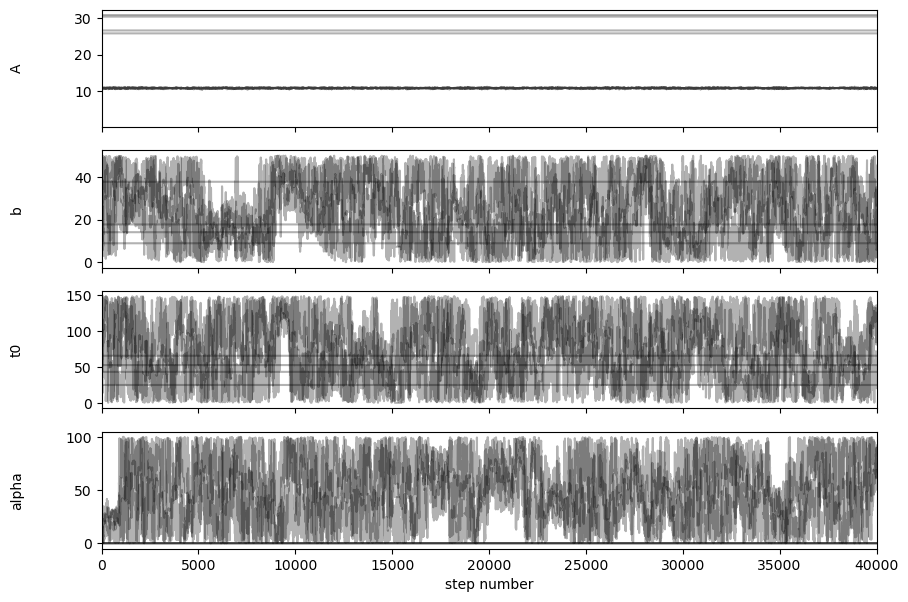

In [27]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["A","b","t0","alpha"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");